<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

08.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 138911868 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 4745908 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,95000.0


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,660000.0


In [6]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1500000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1500000) ]

In [7]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [8]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [10]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,price_paid
150545,2,1,2,9.0,45.684818,3.239838,19.0,11.2,10.0,56250.00000,55250.0000,11,28562039900,2739146000,13429816000,117000.0
868920,3,2,4,9.0,101.312489,1.588494,15.0,12.4,9.8,55833.33333,55125.0000,11,23559506000,4597570000,7811565000,178000.0
811456,3,2,3,1.0,62.266313,0.811141,12.0,10.1,8.9,83750.00000,72500.0000,7,16501493000,11294258000,8988974000,195000.0
79615,2,2,2,8.0,68.528728,1.421918,54.0,7.2,5.4,101666.66670,101666.6667,3,4773717000,28227381000,19348999000,228000.0
992215,4,2,4,1.0,21.743790,4.446872,14.0,11.4,10.5,72000.00000,76825.0000,10,16944124000,9115640000,5017891000,350000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37012,2,2,2,12.0,83.391873,0.505828,33.0,8.3,7.4,72500.00000,71250.0000,9,16056198000,25475829000,21719709000,200000.0
734949,3,2,2,26.0,100.704868,0.373029,47.0,8.3,7.4,37500.00000,46500.0000,4,28643368900,4463433000,12921625000,85000.0
712390,3,2,4,4.0,32.633767,3.365408,35.0,10.5,9.3,142500.00000,121666.6667,19,4724374000,22800088000,12059248000,452000.0
653983,3,2,3,1.0,2.317399,5.742511,9.0,11.7,10.3,75750.00000,82250.0000,18,21676438000,27882109000,18298612000,208500.0


In [12]:
dataset = df_train_test_data.values
dataset

array([[2, '1', '2', ..., 2739146000, 13429816000, 117000.0],
       [3, '2', '4', ..., 4597570000, 7811565000, 178000.0],
       [3, '2', '3', ..., 11294258000, 8988974000, 195000.0],
       ...,
       [3, '2', '4', ..., 22800088000, 12059248000, 452000.0],
       [3, '2', '3', ..., 27882109000, 18298612000, 208500.0],
       [4, '2', '4', ..., 26069056900, 14798919000, 410000.0]],
      dtype=object)

In [13]:
X1 = dataset[:,0:15]
Y1 = dataset[:,15]
#all features

In [14]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 26771245000, 16701868000, 314000.0],
       [1, '2', '2', ..., 26684681000, 17218624000, 225000.0],
       [1, '1', '1', ..., 30370523000, 19027695000, 120000.0],
       ...,
       [5, '2', '4', ..., 27433863000, 19483321000, 560000.0],
       [5, '2', '2', ..., 32765304000, 21992537000, 542000.0],
       [5, '2', '4', ..., 34075107000, 23460630000, 412000.0]],
      dtype=object)

In [15]:
X_Validation=validation_dataset[:,0:15]
Y_Validation =validation_dataset[:,15]

In [16]:
from sklearn import preprocessing

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()

In [18]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.25      , 0.        , 0.33333333, ..., 0.58212889, 0.06016837,
        0.35617444],
       [0.5       , 1.        , 1.        , ..., 0.48006595, 0.10170958,
        0.20641727],
       [0.5       , 1.        , 0.66666667, ..., 0.33606663, 0.25140014,
        0.23780167],
       ...,
       [0.5       , 1.        , 1.        , ..., 0.09578694, 0.50858909,
        0.31964129],
       [0.5       , 1.        , 0.66666667, ..., 0.44164714, 0.62218712,
        0.48595452],
       [0.75      , 1.        , 1.        , ..., 0.15001324, 0.5816601 ,
        0.39266853]])

In [19]:

print(min(Y1))
print(max(Y1))

12000.0
1499999.0


In [20]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.01512504, 0.59735606,
        0.44339255],
       [0.        , 1.        , 0.33333333, ..., 0.04215137, 0.5954211 ,
        0.45716693],
       [0.        , 0.        , 0.        , ..., 0.21022165, 0.67781045,
        0.50538858],
       ...,
       [1.        , 1.        , 1.        , ..., 0.14095121, 0.61216751,
        0.51753351],
       [1.        , 1.        , 0.33333333, ..., 0.15340921, 0.73134081,
        0.58441786],
       [1.        , 1.        , 1.        , ..., 0.17056146, 0.76061873,
        0.62355058]])

In [21]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
1495000.0


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [24]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(1010056, 15) (112229, 15) (1010056,) (112229,)


In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [27]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [28]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,3.0,2.0,3.0,11.0,112.430323,0.465078,62.0,7.4,6.6,26333.33333,28175.00000,9.0,3.227864e+10,6.541931e+09,1.685496e+10,130000,1.069012e+05,23098.8,5.33555e+08,23098.8,322786450_65419309_168549630
1,4.0,2.0,4.0,7.0,26.239445,2.001970,11.0,9.5,8.8,118500.00000,118500.00000,3.0,1.377614e+10,1.790404e+10,6.848837e+09,468000,5.129126e+05,-44912.6,2.01715e+09,44912.6,137761400_179040390_68488370
2,2.0,2.0,3.0,2.0,39.019911,2.062609,17.0,8.8,8.7,85500.00000,90000.00000,4.0,1.341561e+10,2.458238e+10,1.979559e+10,197500,2.175913e+05,-20091.3,4.03662e+08,20091.3,134156100_245823850_197955890
3,3.0,2.0,3.0,1.0,0.000000,0.000000,0.0,0.0,0.0,46658.33333,45666.66667,25.0,2.108074e+10,2.112880e+10,1.265755e+10,135950,1.325234e+05,3426.64,1.17418e+07,3426.64,210807419_211288020_126575470
4,3.0,2.0,3.0,4.0,115.866103,0.478331,42.0,10.0,9.0,58333.33333,60000.00000,6.0,1.736467e+10,2.830303e+10,2.441740e+10,198000,1.723890e+05,25611,6.55921e+08,25611,173646670_283030320_244173950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112224,3.0,2.0,3.0,24.0,67.097747,1.120394,44.0,9.0,8.1,61500.00000,62000.00000,22.0,2.672929e+10,7.186320e+08,1.195502e+10,150000,1.814836e+05,-31483.6,9.9122e+08,31483.6,267292870_7186320_119550160
112225,3.0,2.0,3.0,8.0,26.358552,2.514967,22.0,10.4,9.0,45166.66667,53000.00000,14.0,3.808487e+10,1.576444e+10,2.631008e+10,80000,1.407973e+05,-60797.3,3.69631e+09,60797.3,380848720_157644370_263100829
112226,3.0,2.0,4.0,9.0,89.424132,1.072144,16.0,10.4,10.1,120000.00000,113750.00000,5.0,6.102183e+09,2.387289e+10,1.275280e+10,370000,4.111273e+05,-41127.3,1.69146e+09,41127.3,61021830_238728890_127527950
112227,5.0,2.0,3.0,38.0,71.015852,0.878974,20.0,11.4,10.1,282500.00000,250000.00000,13.0,1.131104e+09,2.687285e+10,1.666792e+10,1.075e+06,1.124937e+06,-49937.5,2.49375e+09,49937.5,11311040_268728460_166679230


In [29]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,3.0,2.0,3.0,11.0,112.430323,0.465078,62.0,7.4,6.6,26333.33333,28175.00000,9.0,3.227864e+10,6.541931e+09,1.685496e+10,130000,1.069012e+05,23098.8,5.33555e+08,23098.8,322786450_65419309_168549630,FY1 2SB,BLACKPOOL,FY1
1,4.0,2.0,4.0,7.0,26.239445,2.001970,11.0,9.5,8.8,118500.00000,118500.00000,3.0,1.377614e+10,1.790404e+10,6.848837e+09,468000,5.129126e+05,-44912.6,2.01715e+09,44912.6,137761400_179040390_68488370,GL53 0PB,CHELTENHAM,GL53
2,2.0,2.0,3.0,2.0,39.019911,2.062609,17.0,8.8,8.7,85500.00000,90000.00000,4.0,1.341561e+10,2.458238e+10,1.979559e+10,197500,2.175913e+05,-20091.3,4.03662e+08,20091.3,134156100_245823850_197955890,NR17 1PD,BRECKLAND,NR17
3,3.0,2.0,3.0,1.0,0.000000,0.000000,0.0,0.0,0.0,46658.33333,45666.66667,25.0,2.108074e+10,2.112880e+10,1.265755e+10,135950,1.325234e+05,3426.64,1.17418e+07,3426.64,210807419_211288020_126575470,NP12 3HF,CAERPHILLY,NP12
4,3.0,2.0,3.0,4.0,115.866103,0.478331,42.0,10.0,9.0,58333.33333,60000.00000,6.0,1.736467e+10,2.830303e+10,2.441740e+10,198000,1.723890e+05,25611,6.55921e+08,25611,173646670_283030320_244173950,NR31 8TA,GREAT YARMOUTH,NR31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112224,3.0,2.0,3.0,24.0,67.097747,1.120394,44.0,9.0,8.1,61500.00000,62000.00000,22.0,2.672929e+10,7.186320e+08,1.195502e+10,150000,1.814836e+05,-31483.6,9.9122e+08,31483.6,267292870_7186320_119550160,M27 8LB,SALFORD,M27
112225,3.0,2.0,3.0,8.0,26.358552,2.514967,22.0,10.4,9.0,45166.66667,53000.00000,14.0,3.808487e+10,1.576444e+10,2.631008e+10,80000,1.407973e+05,-60797.3,3.69631e+09,60797.3,380848720_157644370_263100829,DH3 4HX,COUNTY DURHAM,DH3
112226,3.0,2.0,4.0,9.0,89.424132,1.072144,16.0,10.4,10.1,120000.00000,113750.00000,5.0,6.102183e+09,2.387289e+10,1.275280e+10,370000,4.111273e+05,-41127.3,1.69146e+09,41127.3,61021830_238728890_127527950,RG31 6RB,READING,RG31
112227,5.0,2.0,3.0,38.0,71.015852,0.878974,20.0,11.4,10.1,282500.00000,250000.00000,13.0,1.131104e+09,2.687285e+10,1.666792e+10,1.075e+06,1.124937e+06,-49937.5,2.49375e+09,49937.5,11311040_268728460_166679230,SW19 3AR,MERTON,SW19


In [30]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [31]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

69118.05101160651

In [33]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.671190155842076 %
Predictions where error is 15% or less :53.02461930517068 %
Predictions where error is 20% or less :65.40822781990394 %
Predictions where error is 50% or more :5.839845316272978 %


In [34]:
prediction_validation=regr1.predict(X_Validation_scale)

In [35]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,314000,409870.355665,95870.4,9.19113e+09,95870.4,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,225000,204157.813767,-20842.2,4.34397e+08,20842.2,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,120000,122176.551462,2176.55,4.73738e+06,2176.55,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,500000,408423.744206,-91576.3,8.38621e+09,91576.3,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,52000,52460.233185,460.233,211815,460.233,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37934,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,317000,406593.914219,89593.9,8.02707e+09,89593.9,148740500_304966640_192878440
37935,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,393750,371804.734830,-21945.3,4.81595e+08,21945.3,228863930_47702200_72125650
37936,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,560000,579382.545031,19382.5,3.75683e+08,19382.5,69380650_274338630_194833210
37937,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,542000,751062.150151,209062,4.3707e+10,209062,75486840_327653040_219925370


In [36]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,314000,409870.355665,95870.4,9.19113e+09,95870.4,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,225000,204157.813767,-20842.2,4.34397e+08,20842.2,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,120000,122176.551462,2176.55,4.73738e+06,2176.55,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,500000,408423.744206,-91576.3,8.38621e+09,91576.3,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,52000,52460.233185,460.233,211815,460.233,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37934,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,317000,406593.914219,89593.9,8.02707e+09,89593.9,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
37935,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,393750,371804.734830,-21945.3,4.81595e+08,21945.3,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
37936,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,560000,579382.545031,19382.5,3.75683e+08,19382.5,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
37937,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,542000,751062.150151,209062,4.3707e+10,209062,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [37]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [38]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

69159.64448964658

In [39]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :37.10693481641582 %
Predictions where error is 15% or less :52.17586125095548 %
Predictions where error is 20% or less :64.29004454519097 %
Predictions where error is 50% or more :6.1282585202562005 %


In [40]:
import matplotlib.pyplot as plt

In [41]:
import numpy as np

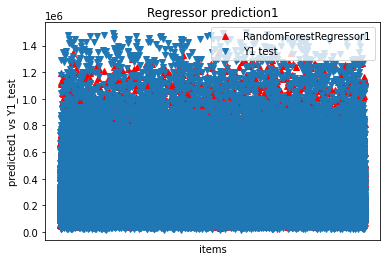

In [42]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

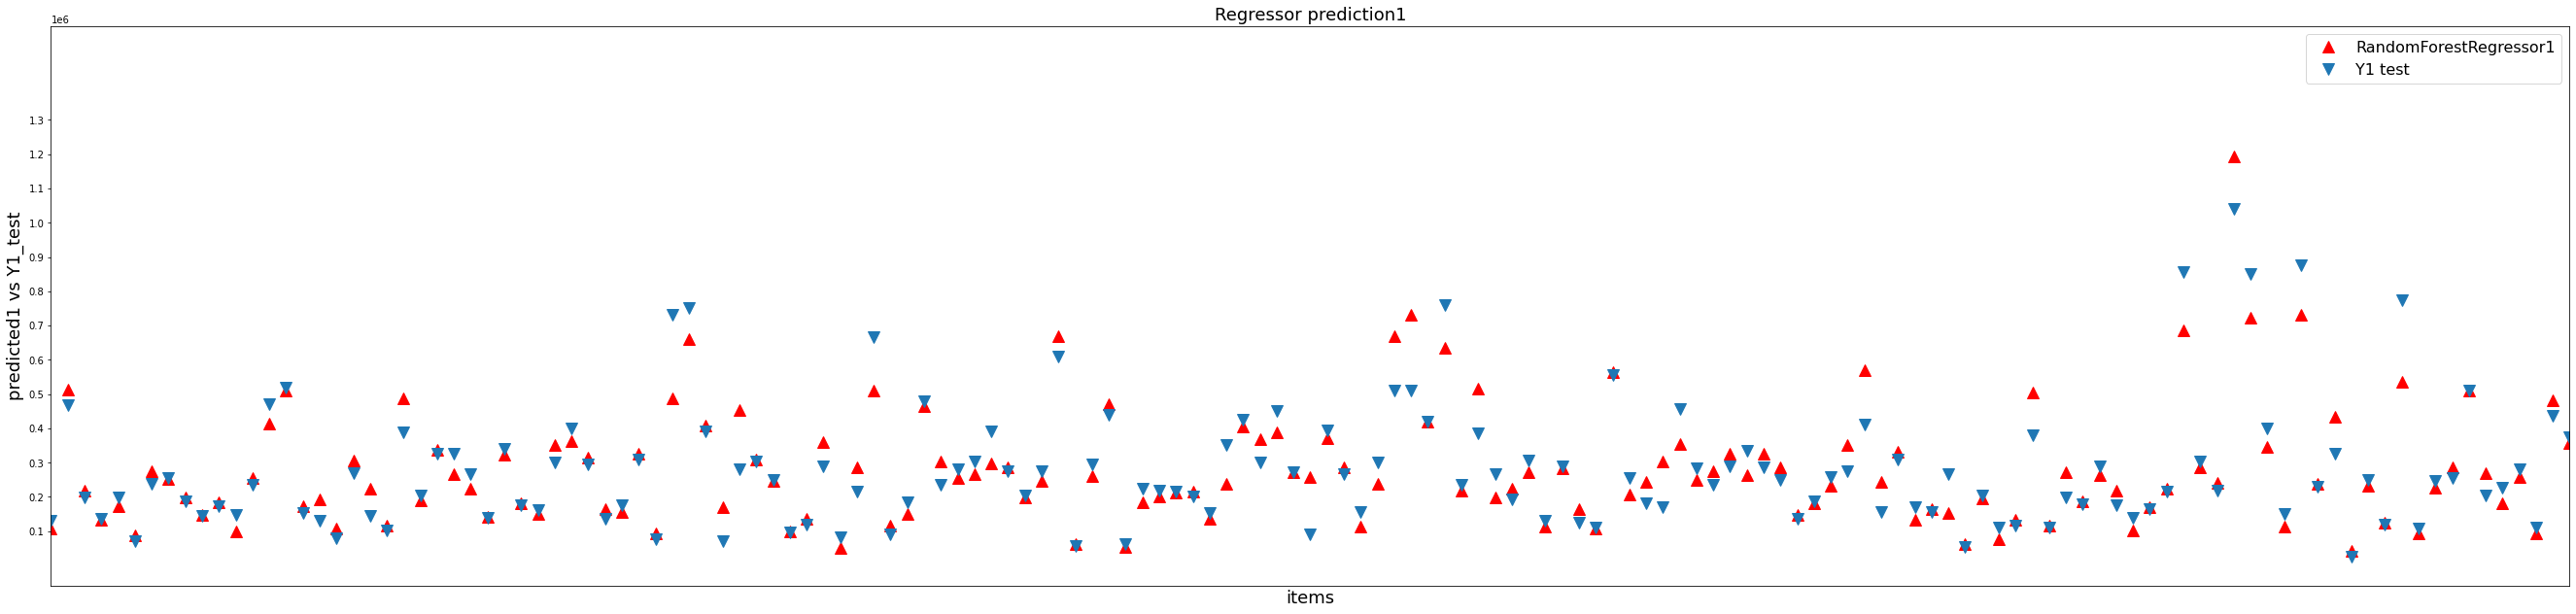

In [43]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [44]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [45]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

69118.05101160661

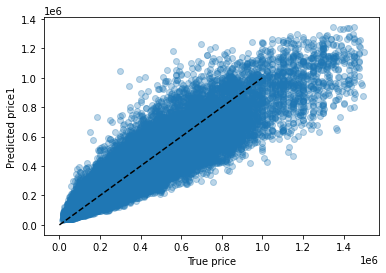

In [46]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [47]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

69159.6444896465

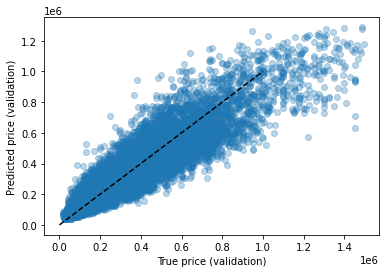

In [48]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()